# Data Extraction

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import gensim
import json
import lyricsgenius
from pandasql import *
mysql = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
from lyricsgenius import Genius 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import pairwise_distances

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grink\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grink\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [102]:
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
client_id = 'Enter Client ID'
token = 'Enter Token'
genius = Genius(token)

#Removes [chorus] [bridge] etc. tags.
genius.remove_section_headers = True

#excluding repeat songs that might hinder analysis
genius.excluded_terms = ["(Remix)", "(Live)"]
#artist = genius.search_artist("Kendrick Lamar", max_songs=10)

In [8]:
albums = []

while True:
    try:
        albums.append(genius.search_album("Utopia","Travis Scott"))
        albums.append(genius.search_album("Astroworld","Travis Scott"))
        albums.append(genius.search_album("Birds in the Trap Sing McKnight","Travis Scott"))
        albums.append(genius.search_album("Rodeo","Travis Scott"))
        break
    except:
        pass

#save lyrics to files and seperate them to analyse by albums

Searching for "Utopia" by Travis Scott...
Searching for "Astroworld" by Travis Scott...
Searching for "Birds in the Trap Sing McKnight" by Travis Scott...
Searching for "Rodeo" by Travis Scott...


In [10]:
for i in range(len(albums)):
    albums[i].save_lyrics()

Wrote Lyrics_UTOPIA.json.
Wrote Lyrics_ASTROWORLD.json.
Wrote Lyrics_BirdsintheTrapSingMcKnight.json.
Wrote Lyrics_Rodeo.json.


In [18]:
utp1 = json.load(open("/Users/grink/travis-scott-song-analyzer/Lyrics/Lyrics_UTOPIA.json"))
asw1 = json.load(open("/Users/grink/travis-scott-song-analyzer/Lyrics/Lyrics_ASTROWORLD.json"))
mck1 = json.load(open("/Users/grink/travis-scott-song-analyzer/Lyrics/Lyrics_BirdsintheTrapSingMcKnight.json"))
rod1 = json.load(open("/Users/grink/travis-scott-song-analyzer/Lyrics/Lyrics_Rodeo.json"))

#normalizing json into dataframe

utp = pd.json_normalize(utp1['tracks'])
asw = pd.json_normalize(asw1['tracks'])
mck = pd.json_normalize(mck1['tracks'])
rod = pd.json_normalize(rod1['tracks'])

#add all albums into one master
album_master = [utp, asw, mck,rod]

In [20]:
#add album names to aggregate into dataframe later

utp_names = []
for i in range(len(utp)):
    utp_names.append("Utopia (2023)")

asw_names = []
for i in range(len(asw)):
    asw_names.append("Astroworld (2018)")

mck_names= []
for i in range(len(mck)):
    mck_names.append("Bird in the Trap Sing McKnight (2016)")

rod_names = []
for i in range(len(rod)):
    rod_names.append("Rodeo (2015)")

album_name = [utp_names, asw_names, mck_names, rod_names]

for i in range(len(album_master)):
    album_master[i]["AlbumName"] = album_name[i]

# Data Cleaning

In [25]:
#using rgex to remove punctuation and lowercase letters

for i in range(len(album_master)):
    for j in range(len(album_master[i]["song.lyrics"])):
        album_master[i]["song.lyrics"][j] = album_master[i]["song.lyrics"][j].replace("\n", ". ").replace("\n\n", '')
        album_master[i]["song.lyrics"][j] = re.sub("[^a-zA-Z0-9 -]", '', album_master[i]["song.lyrics"][j]).lower()

C:\Users\grink\AppData\Local\Temp\ipykernel_27000\3889695053.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  album_master[i]["song.lyrics"][j] = album_master[i]["song.lyrics"][j].replace("\n", ". ").replace("\n\n", '')
C:\Users\grink\App

In [59]:
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
more_stop_words = ["gon", "em", "yeah", "uh", "could", "ima"]

# Map POS tag to first character lemmatizing_and_stop() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Funtion to lemmatize words and remove stop words
def lemmatizing_and_stop(lyrics):
    prac = [lemmatizer.lemmatize(lyric, get_wordnet_pos(lyric)) for lyric in nltk.word_tokenize(lyrics)]
    return ' '.join([lyric for lyric in prac if lyric not in stop_words or more_stop_words])

# Lemmatizing lyrics and removing stop words from them
for i in range(len(album_master)):
    for j in range(len(album_master[i][["song.lyrics"]])):
        album_master[i]["song.lyrics"] = album_master[i]["song.lyrics"].apply(lambda lyric: lemmatizing_and_stop(lyric))

In [29]:
# finding unique word count and adding it to the dataframe

def finding_number(lyrics):
    #storing the data in a set, since set doesn't take repeats
    place_set = set()
    place_set.update(lyrics.split(' '))
    number = len(place_set)/ len(lyrics.split(' '))
    return number

for i in range(len(album_master)):
    album_master[i]["UniqueWordsPercent"] = album_master[i]["song.lyrics"].apply(lambda lyric: finding_number(lyric))
    

In [31]:
#selecting only the important columns for anaalysis and removing instrumental songs

for i in range(len(album_master)):
    #no travis scott song has all unique words except ones with no lyrics, hence unique words % as 1
    album_master[i] = album_master[i][album_master[i]["UniqueWordsPercent"] != 1]
    album_master[i] = album_master[i][["song.full_title","song.artist_names","song.lyrics","UniqueWordsPercent","AlbumName"]]
    

In [61]:
#merging the tables to create a large table master

final_table = pd.concat([album_master[i] for i in range(len(album_master))], axis = 0)

#adding id column to the table

final_table["id"] = [i for i in range(len(final_table))]
final_table.set_index("id", inplace = True)
travis = final_table.copy()
final_table.head(5)

,song.full_title,song.artist_names,song.lyrics,UniqueWordsPercent,AlbumName
id,,,,,
0,HYAENA by Travis Scott,Travis Scott,162 contributorstranslationsportugusespaoltrke...,0.462012,Utopia (2023)
1,THANK GOD by Travis Scott,Travis Scott,137 contributorstranslationsportugusespaoltrke...,0.507289,Utopia (2023)
2,MODERN JAM by Travis Scott (Ft. Teezo Touchdown),Travis Scott (Ft. Teezo Touchdown),189 contributorstranslationsespaolportugusdeut...,0.487500,Utopia (2023)
3,MY EYES by Travis Scott,Travis Scott,268 contributorstranslationsespaolportugustrke...,0.436923,Utopia (2023)
4,GOD’S COUNTRY by Travis Scott,Travis Scott,164 contributorstranslationsportugusespaolital...,0.431734,Utopia (2023)


# Exploratory Data Analysis

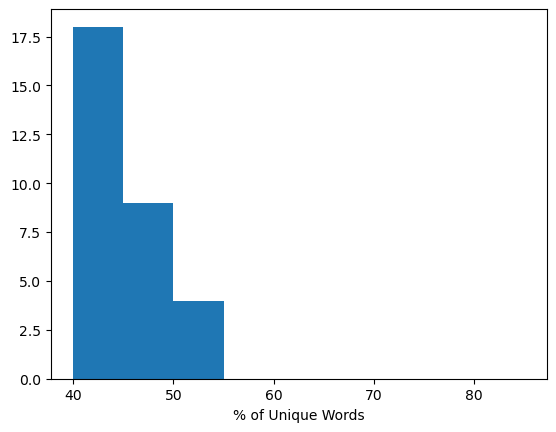

In [69]:
#using SQL to query display data

query_for_uw = "SELECT UniqueWordsPercent*100 as uwp FROM travis"
plt.hist(mysql(query_for_uw)["uwp"], bins = [i for i in range(40,90,5)])
plt.xlabel("% of Unique Words")
plt.show()

looking at the plot, we can see that Travis Scott has around 12-17% unique words in his songs. this shows travis likes to use few words to make the song catchy and interesting. the data is skewed to the right, which shows few songs are just rap with no focus on chorus making them less sellable

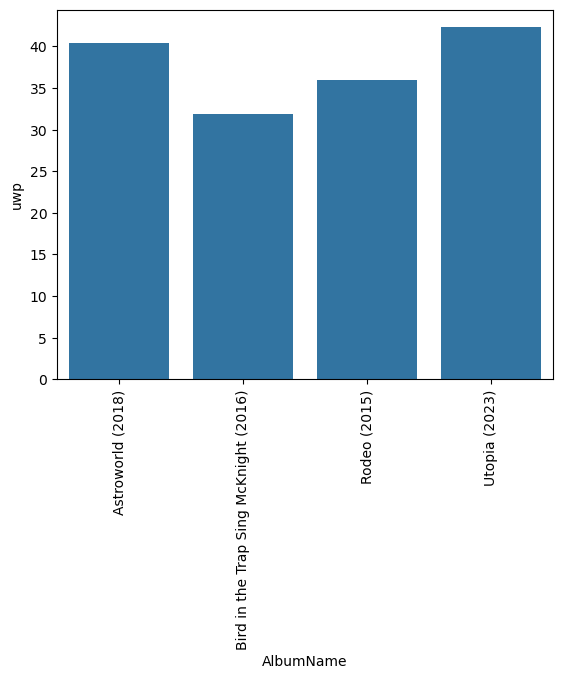

In [78]:
#aggregating average of uniquewordspercent to find out which albums have uwp
#displayed as a barplot

query_for_uw_grouped = "SELECT AVG(UniqueWordsPercent*100) as uwp, AlbumName FROM travis GROUP BY AlbumName"
temptable = mysql(query_for_uw_grouped)
sns.barplot(x = temptable["AlbumName"], y= temptable["uwp"])
plt.xticks(rotation = 90)
plt.show()

looking at the plot, in these four albums we see that travis has used 30% unique words. highest in utopia and lowest in mcknight. 
to undertsand the main themes of his music:
1. first we count vectorize, to put his muic lyrics in columns.
2. each column then becomes a word for every song (row)
3. this has a 1 or 0 in that row, whether lyrics contain that word or not

In [95]:
#first we tokenize all lyrics so we can input into our model

all_tokens = []
for i in range(len(travis)):
    tokenized = nltk.word_tokenize(travis.iloc[i]["song.lyrics"])
    all_tokens.append(tokenized)

# adding more stop words after reading lyrics that I missed
more_stop_words_two = ["me", "my", "and", "to", "in", "hey", "like", "yeah", "im", "go", "know", "get", "shit"]

#amking stop_words into frozenset for Count Vectorization to recognize
# stop_agg = frozenset([i for i in stop_words]).union(frozenset([i for i in more_stop_words])).union(frozenset([i for i in more_stop_words_two]))
stop_agg = list(set(stop_words) | set(more_stop_words) | set(more_stop_words_two))

#count vectorization of data
count_vectorizer = CountVectorizer(tokenizer = lambda doc: doc, lowercase = False, stop_words = stop_agg)

#fitting and transforming lyrics to columns
dtm_count = count_vectorizer.fit_transform(all_tokens)

#counting number of terms
terms = count_vectorizer.get_feature_names_out()

len(terms)

C:\Users\grink\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\grink\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


3450

we see that there are 3450 columns in the dataframe. we use LDA (Linear Discrimant Analysis) to find groupings of common words. LDA is an unsupervised learning method, where it categorises words into groups based on the text given. it assumes topics are correlated. assumes they are correlated to a mix of the words of the topic. 

we use the model to create a probability distribution of words in categories.

In [112]:
lda = LatentDirichletAllocation(n_components = 7, random_state = 42)

#fitting and transforming the data, this will produce an array with numbers which are diifcult to understand

topics = lda.fit_transform(dtm_count)

topics_word = {}

#we run this to get the top words in each topic

for topic, comp in enumerate(lda.components_):
    indexed = np.argsort(comp)[::-1][:10]
    #argsort() return n dimension sorted arry of arr in DESC
    topics_word[topic] = [terms[i] for i in indexed]
    #storing the words to the topic

for topic, words in topics_word.items():
    print('Topic: %d' %topic)
    print(' %s' %', '.join(words))

Topic: 0
 love, time, see, woah, dont, yall, long, might, come, feel
Topic: 1
 night, late, oh, dont, time, show, ooh, back, ya, nigga
Topic: 2
 high, never, yah, flyin, nigga, baby, aint, sweet, dont, youre
Topic: 3
 let, fuck, call, drunk, friend, back, ayy, aint, club, time
Topic: 4
 nigga, la, fen, trill, bitch, aint, only-only-only, back, god, tryna
Topic: 5
 drink, tell, pop, smoke, one, baby, thang, new, ooh, nigga
Topic: 6
 side, oh, order, night, dont, ooh, right, want, money, tell


Word Groupings:
1. Love
2. Nightlife
3. Drugs
4. Friendship
5. Lifestyle
6. Celebrating
7. Money 

In [166]:
topics_dict = {'topic1' : "Love", 
               "topic2" : "Nightlife", 
               "topic3" : "Drugs", 
               "topic4" : "Friendship", 
               "topic5" : "Lifestyle", 
               'topic6' : "Celebrating", 
               "topic7" :"Money"}

In [174]:
# topics_dict = pd.DataFrame(topics.round(4), columns=[f"topic_{i}" for i in range(1, 8)])
topics_df = pd.DataFrame(topics.round(4), columns = [1, 2, 3, 4, 5, 6, 7]).add_prefix("topic")
topics_df["lyrics"] = final_table["song.lyrics"]
topics_df["id1"] = range(64)
topics_df

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,lyrics,id1
0,0.0008,0.9954,0.0008,0.0008,0.0008,0.0008,0.0008,162 contributorstranslationsportugusespaoltrke...,0
1,0.9742,0.0008,0.0218,0.0008,0.0008,0.0008,0.0008,137 contributorstranslationsportugusespaoltrke...,1
2,0.0008,0.0008,0.0008,0.9955,0.0008,0.0008,0.0008,189 contributorstranslationsespaolportugusdeut...,2
3,0.0005,0.0005,0.0005,0.2655,0.0005,0.7320,0.0005,268 contributorstranslationsespaolportugustrke...,3
4,0.0008,0.0008,0.0008,0.0008,0.9954,0.0008,0.0008,164 contributorstranslationsportugusespaolital...,4
...,...,...,...,...,...,...,...,...,...
59,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.9952,155 contributorstranslationstrkeespaolportugus...,59
60,0.0003,0.0003,0.0003,0.9983,0.0003,0.0003,0.0003,209 contributorstranslationstrkeespaolportugus...,60
61,0.0007,0.0007,0.9961,0.0007,0.0007,0.0007,0.0007,81 contributorstranslationstravis scott - fly ...,61
62,0.0006,0.0006,0.0006,0.0006,0.0006,0.9966,0.0006,122 contributorstranslationsespaolportugustrav...,62


In [180]:
#merging the two tables

merge_query = "SELECT * FROM final_table INNER JOIN topics_df ON final_table.id = topics_df.id1"
merged_table = mysql(merge_query).drop("lyrics",axis = 1).drop("id1", axis = 1)
merged_table.to_csv('table_with_topics.csv')
merged_table

,id,song.full_title,song.artist_names,song.lyrics,UniqueWordsPercent,AlbumName,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,0,HYAENA by Travis Scott,Travis Scott,162 contributorstranslationsportugusespaoltrke...,0.462012,Utopia (2023),0.0008,0.9954,0.0008,0.0008,0.0008,0.0008,0.0008
1,1,THANK GOD by Travis Scott,Travis Scott,137 contributorstranslationsportugusespaoltrke...,0.507289,Utopia (2023),0.9742,0.0008,0.0218,0.0008,0.0008,0.0008,0.0008
2,2,MODERN JAM by Travis Scott (Ft. Teezo Touchdown),Travis Scott (Ft. Teezo Touchdown),189 contributorstranslationsespaolportugusdeut...,0.487500,Utopia (2023),0.0008,0.0008,0.0008,0.9955,0.0008,0.0008,0.0008
3,3,MY EYES by Travis Scott,Travis Scott,268 contributorstranslationsespaolportugustrke...,0.436923,Utopia (2023),0.0005,0.0005,0.0005,0.2655,0.0005,0.7320,0.0005
4,4,GOD’S COUNTRY by Travis Scott,Travis Scott,164 contributorstranslationsportugusespaolital...,0.431734,Utopia (2023),0.0008,0.0008,0.0008,0.0008,0.9954,0.0008,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,Impossible by Travis Scott,Travis Scott,155 contributorstranslationstrkeespaolportugus...,0.320000,Rodeo (2015),0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.9952
60,60,Maria I'm Drunk by Travis Scott (Ft. Justin Bi...,Travis Scott (Ft. Justin Bieber & Young Thug),209 contributorstranslationstrkeespaolportugus...,0.273769,Rodeo (2015),0.0003,0.0003,0.0003,0.9983,0.0003,0.0003,0.0003
61,61,Flying High by Travis Scott (Ft. Toro y Moi),Travis Scott (Ft. Toro y Moi),81 contributorstranslationstravis scott - fly ...,0.299304,Rodeo (2015),0.0007,0.0007,0.9961,0.0007,0.0007,0.0007,0.0007
62,62,I Can Tell by Travis Scott,Travis Scott,122 contributorstranslationsespaolportugustrav...,0.368613,Rodeo (2015),0.0006,0.0006,0.0006,0.0006,0.0006,0.9966,0.0006


now that we have the merged table, we can see how the topics change every album. we can also see % of prevalenece of topics per album and display as a line graph

In [188]:
#grouping table using mean

grouped = merged_table[["AlbumName","topic1","topic2","topic3","topic4","topic5","topic6","topic7"]].groupby("AlbumName").mean()
grouped

,topic1,topic2,topic3,topic4,topic5,topic6,topic7
AlbumName,,,,,,,
Astroworld (2018),0.097765,0.242700,0.191859,0.172318,0.168771,0.067365,0.059229
Bird in the Trap Sing McKnight (2016),0.071650,0.350014,0.285086,0.142886,0.071750,0.071621,0.006936
Rodeo (2015),0.072893,0.076636,0.148671,0.079986,0.214014,0.143350,0.264514
Utopia (2023),0.150705,0.060579,0.108758,0.376295,0.159453,0.039126,0.105126


In [190]:
#group table by alphabetical order and year

index_as_list = grouped.index.tolist()

#extracting only digits from the list and storing in another list

year = []
for album in index_as_list:
    year.append(re.findall(r"\([^\d]*(\d+)[^\d]*\)", album))

grouped["year"] = year

#sorting by year
final_grouped = grouped.sort_values('year').drop('year', axis = 1).rename(columns = topics_dict)

final_grouped

,Love,Nightlife,Drugs,Friendship,Lifestyle,Celebrating,Money
AlbumName,,,,,,,
Rodeo (2015),0.072893,0.076636,0.148671,0.079986,0.214014,0.143350,0.264514
Bird in the Trap Sing McKnight (2016),0.071650,0.350014,0.285086,0.142886,0.071750,0.071621,0.006936
Astroworld (2018),0.097765,0.242700,0.191859,0.172318,0.168771,0.067365,0.059229
Utopia (2023),0.150705,0.060579,0.108758,0.376295,0.159453,0.039126,0.105126


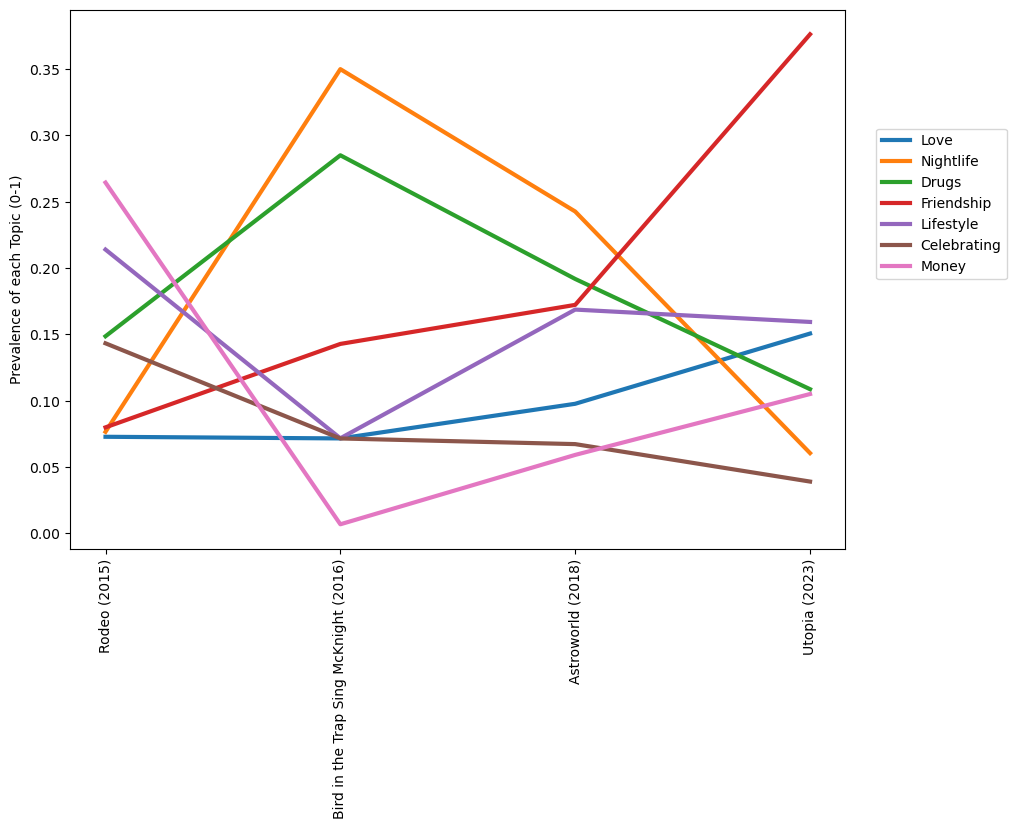

In [192]:
#plotting the graph 
plt.figure(figsize= (10,7))
plt.plot(final_grouped, linewidth = 3)
plt.xticks(rotation = 90)
plt.ylabel("Prevalence of each Topic (0-1)")
plt.legend(final_grouped.columns, loc=(1.04,0.5))
plt.show()

# Recommedation System

In [225]:
def top5(songname, artist,tokened_list):
    temp = all_tokens.copy()

#check if song exists
    try:
        songlyrics = genius.search_song(songname,artist).lyrics
    except:
        return "Song Not Found"
#appending lyrics to top of tokenized list
    temp.insert(0, nltk.word_tokenize(songlyrics))

#performing CV and LDA
    temp_dtm_count = count_vectorizer.fit_transform(temp)
    temp_topics = lda.fit_transform(temp_dtm_count)

    distances = pairwise_distances(temp_topics, metric='cosine')
    dist_df = pd.DataFrame(data = distances, index = range(len(temp)), columns= range(len(temp)))

#use heapsort to sort the top 5
    sorted_list = np.argsort(dist_df, kind = "heapsort")

#picking closest song
    topsongsindex = sorted_list[-5:]

    recc_names = []
    for i in topsongsindex:
        onesongname = merged_table.iloc[i-1]
        recc_names.append(onesongname["song.full_title"])

    return recc_names

top5("The Color Violet","Tory Lanez",all_tokens)

Searching for "The Color Violet" by Tory Lanez...
Done.


C:\Users\grink\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[59                           Impossible by Travis Scott
 47                                 lose by Travis Scott
 62                           I Can Tell by Travis Scott
 38                           coordinate by Travis Scott
 50                          Pornography by Travis Scott
                             ...                        
 46    pick up the phone by Young Thug & Travis Scott...
 10    TOPIA TWINS by Travis Scott (Ft. 21 Savage & R...
 17       TELEKINESIS by Travis Scott (Ft. Future & SZA)
 60    Maria I'm Drunk by Travis Scott (Ft. Justin Bi...
 52         3500 by Travis Scott (Ft. 2 Chainz & Future)
 Name: song.full_title, Length: 65, dtype: object,
 60    Maria I'm Drunk by Travis Scott (Ft. Justin Bi...
 10    TOPIA TWINS by Travis Scott (Ft. 21 Savage & R...
 23    STOP TRYING TO BE GOD by Travis Scott (Ft. Jam...
 14     LOST FOREVER by Travis Scott (Ft. Westside Gunn)
 48                             guidance by Travis Scott
                             ...     